<a href="https://colab.research.google.com/github/seunghokimS/DACON-Subscriber-prediction-/blob/main/%E1%84%80%E1%85%AE%E1%84%83%E1%85%A9%E1%86%A8%E1%84%8B%E1%85%A8%E1%84%8E%E1%85%B3%E1%86%A8(dacon)EDA%2BBasic_DTmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install lightgbm


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, make_scorer
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
# from lightgbm import LGBMClassifier

import optuna
from optuna.visualization import plot_param_importances

from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

In [ ]:
train = pd.read_csv("/Users/seungho/Desktop/승호/공모전 및 프로젝트/데이콘/데이콘 이용자 구독예측/dataset/train.csv")
test = pd.read_csv("/Users/seungho/Desktop/승호/공모전 및 프로젝트/데이콘/데이콘 이용자 구독예측/dataset/test.csv")
submission = pd.read_csv("/Users/seungho/Desktop/승호/공모전 및 프로젝트/데이콘/데이콘 이용자 구독예측/dataset/sample_submission.csv")


# EDA

In [ ]:
train.head()

,user_id,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,customer_inquiry_history,payment_pattern,target
0,b919c29d,13,14,14.946163,8.427187,18,16,68.360455,3,4,Low,Basic,4,5,0
1,a0a60abb,16,18,18.453224,72.646087,16,13,97.567322,2,3,Medium,Basic,1,6,1
2,b9f171ae,22,1,16.195228,21.774492,13,14,94.358763,3,4,Medium,Premium,0,7,1
3,5dc0ba8b,1,19,17.628656,42.659066,19,18,70.153228,0,3,Low,Basic,1,0,1
4,65c83654,4,5,21.390656,30.744287,19,10,81.917908,2,4,Medium,Basic,3,0,1


In [ ]:
test.head()

,user_id,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,customer_inquiry_history,payment_pattern
0,0001d6e9,9,15,11.173051,7.047243,19,15,82.074557,3,5,Low,Premium,2,7
1,0002c77d,11,8,13.448592,24.583327,10,16,80.546040,4,2,Low,Basic,4,4
2,0002df5b,11,28,18.548201,1.707616,9,19,73.676957,5,5,Low,Premium,1,3
3,000b6068,14,17,13.383311,21.391389,12,6,63.314635,0,4,High,Premium,1,5
4,00184a0c,19,6,11.919663,18.126987,8,15,55.899647,1,4,Medium,Basic,1,3


- user_id :	사용자의 고유 식별자
- subscription_duration :	사용자가 서비스에 가입한 기간 (월)
- recent_login_time : 	사용자가 마지막으로 로그인한 시간 (일)
- average_login_time :	사용자의 일반적인 로그인 시간
- average_time_per_learning_session :	각 학습 세션에 소요된 평균 시간 (분)
- monthly_active_learning_days :	월간 활동적인 학습 일수
- total_completed_courses :	완료한 총 코스 수
- recent_learning_achievement :	최근 학습 성취도
- abandoned_learning_sessions :	중단된 학습 세션 수
- community_engagement_level :	커뮤니티 참여도
- preferred_difficulty_level :	선호하는 난이도
- subscription_type	구독 유형
- customer_inquiry_history	고객 문의 이력
- payment_pattern : 	"사용자의 지난 3개월 간의 결제 패턴을 10진수로 표현한 값.
    - 7: 3개월 모두 결제함
    - 6: 첫 2개월은 결제했으나 마지막 달에는 결제하지 않음
    - 5: 첫 달과 마지막 달에 결제함
    - 4: 첫 달에만 결제함
    - 3: 마지막 2개월에 결제함
    - 2: 가운데 달에만 결제함
    - 1: 마지막 달에만 결제함
    - 0: 3개월 동안 결제하지 않음"
- target :	사용자가 다음 달에도 구독을 계속할지 (1) 또는 취소할지 (0)를 나타냅니다.

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   user_id                            10000 non-null  object 
 1   subscription_duration              10000 non-null  int64  
 2   recent_login_time                  10000 non-null  int64  
 3   average_login_time                 10000 non-null  float64
 4   average_time_per_learning_session  10000 non-null  float64
 5   monthly_active_learning_days       10000 non-null  int64  
 6   total_completed_courses            10000 non-null  int64  
 7   recent_learning_achievement        10000 non-null  float64
 8   abandoned_learning_sessions        10000 non-null  int64  
 9   community_engagement_level         10000 non-null  int64  
 10  preferred_difficulty_level         10000 non-null  object 
 11  subscription_type                  10000 non-null  obje

In [ ]:
train.columns

Index(['user_id', 'subscription_duration', 'recent_login_time',
       'average_login_time', 'average_time_per_learning_session',
       'monthly_active_learning_days', 'total_completed_courses',
       'recent_learning_achievement', 'abandoned_learning_sessions',
       'community_engagement_level', 'preferred_difficulty_level',
       'subscription_type', 'customer_inquiry_history', 'payment_pattern',
       'target'],
      dtype='object')

In [ ]:
test.describe()

,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,customer_inquiry_history,payment_pattern
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,12.055700,14.998000,15.026034,55.481839,12.454600,12.197800,75.029148,2.990700,3.905400,2.008100,3.498100
std,6.587635,8.364341,2.984562,56.901447,6.926567,3.647246,10.060532,1.724155,1.273504,1.406923,2.284364
min,1.000000,1.000000,4.304375,0.002851,1.000000,1.000000,39.224932,0.000000,1.000000,0.000000,0.000000
25%,6.000000,8.000000,13.023887,15.796562,6.000000,10.000000,68.297270,2.000000,3.000000,1.000000,2.000000
50%,12.000000,15.000000,15.031312,37.801621,12.000000,12.000000,74.942627,3.000000,4.000000,2.000000,3.000000
75%,18.000000,22.000000,17.051425,75.911356,19.000000,15.000000,81.853699,4.000000,5.000000,3.000000,5.000000
max,23.000000,29.000000,25.707977,606.510444,24.000000,28.000000,117.858556,11.000000,5.000000,10.000000,7.000000


In [ ]:
train.describe()

,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,customer_inquiry_history,payment_pattern,target
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,11.897400,15.013200,14.994076,54.917720,12.545400,12.227500,75.029513,3.043600,3.886100,2.010500,3.502900,0.619900
std,6.600896,8.362573,3.001869,56.024310,6.932239,3.634125,9.968529,1.755052,1.262175,1.420983,2.311261,0.485435
min,1.000000,1.000000,2.366189,0.011515,1.000000,1.000000,35.941755,0.000000,1.000000,0.000000,0.000000,0.000000
25%,6.000000,8.000000,13.025597,15.276611,7.000000,10.000000,68.278054,2.000000,3.000000,1.000000,1.000000,0.000000
50%,12.000000,15.000000,14.979228,37.578818,13.000000,12.000000,75.126061,3.000000,4.000000,2.000000,4.000000,1.000000
75%,18.000000,22.000000,16.995340,75.584200,19.000000,15.000000,81.718976,4.000000,5.000000,3.000000,6.000000,1.000000
max,23.000000,29.000000,26.998490,503.372616,24.000000,27.000000,112.643828,12.000000,5.000000,10.000000,7.000000,1.000000


- 범주형 변수 : countplot
- 수치형 변수 : histplot


- user_id :	사용자의 고유 식별자
- subscription_duration :	사용자가 서비스에 가입한 기간 (월)
- recent_login_time : 	사용자가 마지막으로 로그인한 시간 (일)
- average_login_time :	사용자의 일반적인 로그인 시간
- average_time_per_learning_session :	각 학습 세션에 소요된 평균 시간 (분)
- monthly_active_learning_days :	월간 활동적인 학습 일수
- total_completed_courses :	완료한 총 코스 수
- recent_learning_achievement :	최근 학습 성취도
- abandoned_learning_sessions :	중단된 학습 세션 수
- community_engagement_level :	커뮤니티 참여도
- preferred_difficulty_level :	선호하는 난이도
- subscription_type	구독 유형
- customer_inquiry_history	고객 문의 이력
- payment_pattern : 	"사용자의 지난 3개월 간의 결제 패턴을 10진수로 표현한 값.
    - 7: 3개월 모두 결제함
    - 6: 첫 2개월은 결제했으나 마지막 달에는 결제하지 않음
    - 5: 첫 달과 마지막 달에 결제함
    - 4: 첫 달에만 결제함
    - 3: 마지막 2개월에 결제함
    - 2: 가운데 달에만 결제함
    - 1: 마지막 달에만 결제함
    - 0: 3개월 동안 결제하지 않음"
- target :	사용자가 다음 달에도 구독을 계속할지 (1) 또는 취소할지 (0)를 나타냅니다.

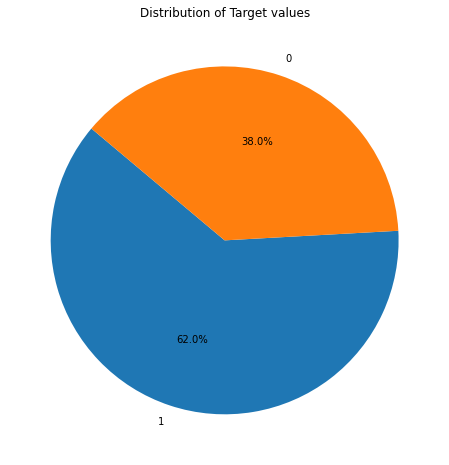

In [ ]:
target_counts = train['target'].value_counts()

plt.figure(figsize=(8,8), facecolor='white')
plt.pie(target_counts, labels = target_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Target values")
plt.show()

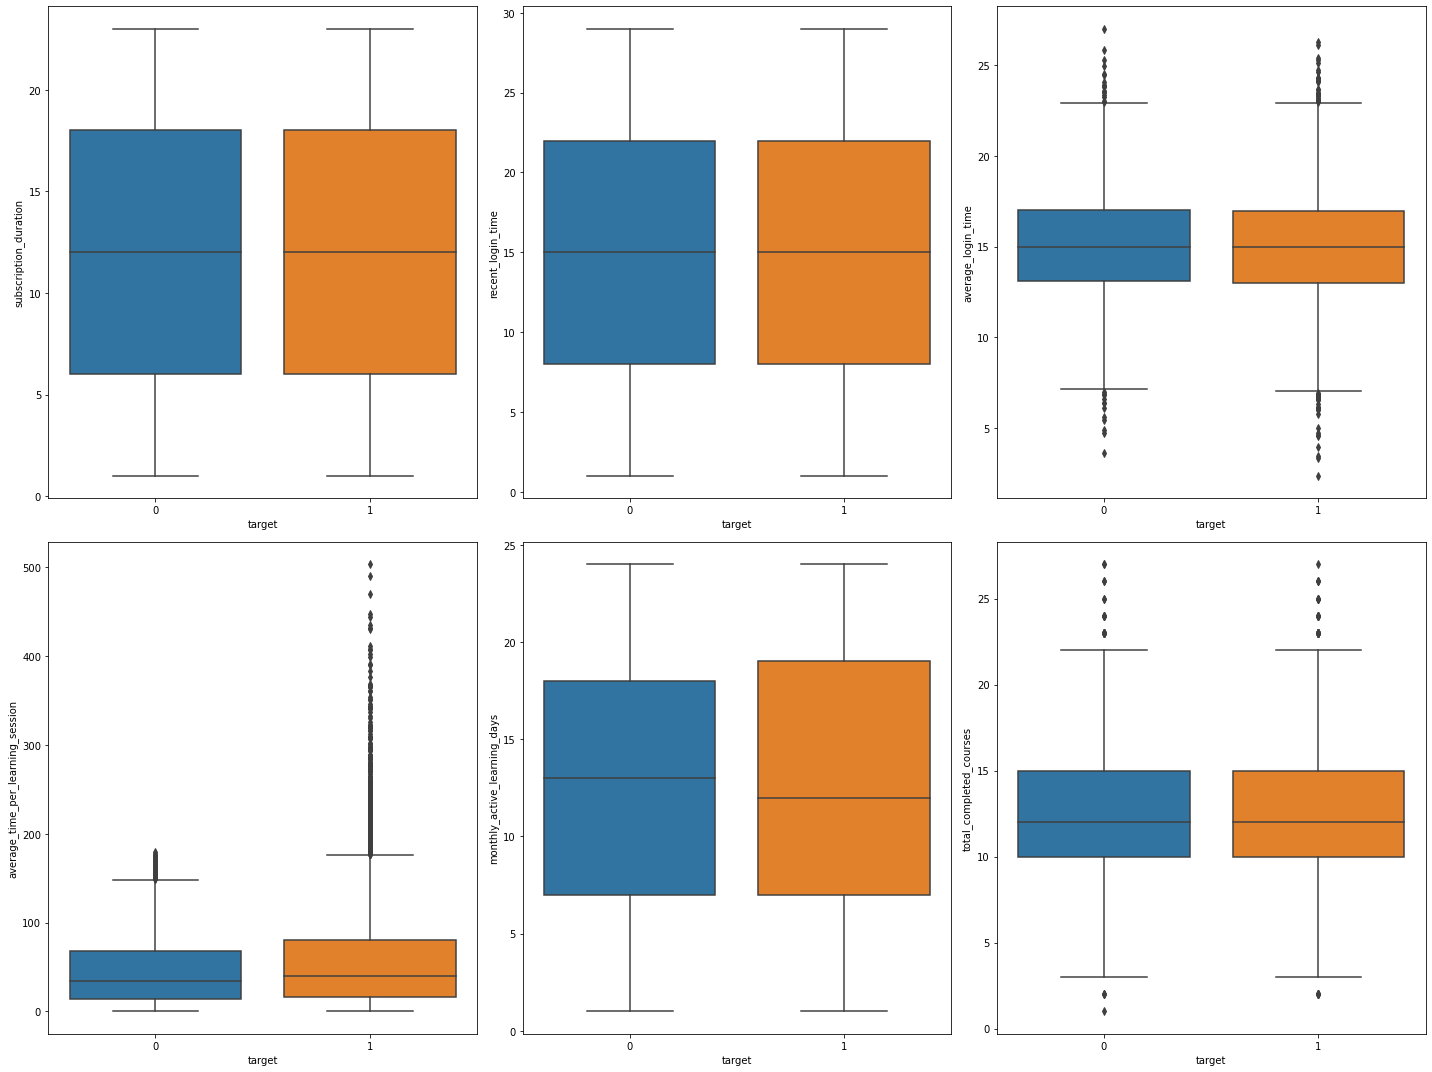

In [ ]:
num_cols = ['subscription_duration', 'recent_login_time', 'average_login_time',
            'average_time_per_learning_session', 'monthly_active_learning_days', 'total_completed_courses']

fig, axes = plt.subplots(2, 3, figsize=(20, 15))

for i, col in enumerate(num_cols):
    row = i // 3
    col = i % 3
    sns.boxplot(x='target', y=num_cols[i], data= train , ax=axes[row, col])

plt.tight_layout()
plt.show()

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   user_id                            10000 non-null  object 
 1   subscription_duration              10000 non-null  int64  
 2   recent_login_time                  10000 non-null  int64  
 3   average_login_time                 10000 non-null  float64
 4   average_time_per_learning_session  10000 non-null  float64
 5   monthly_active_learning_days       10000 non-null  int64  
 6   total_completed_courses            10000 non-null  int64  
 7   recent_learning_achievement        10000 non-null  float64
 8   abandoned_learning_sessions        10000 non-null  int64  
 9   community_engagement_level         10000 non-null  int64  
 10  preferred_difficulty_level         10000 non-null  object 
 11  subscription_type                  10000 non-null  obje

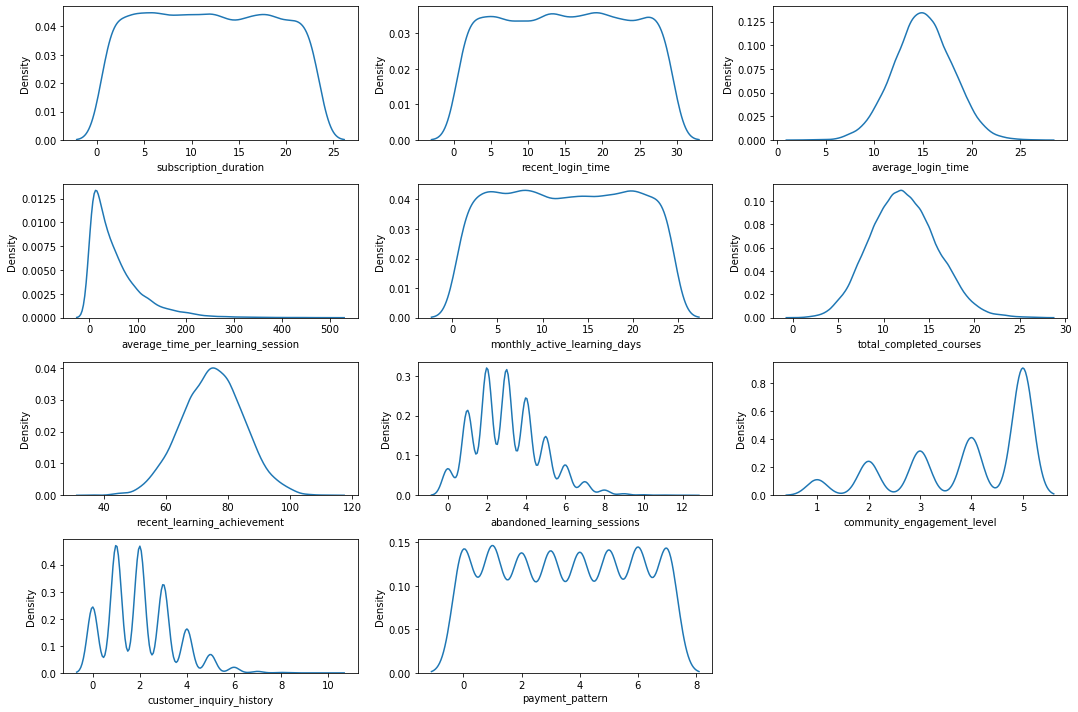

In [ ]:
num_cols  = ['subscription_duration', 'recent_login_time',
       'average_login_time', 'average_time_per_learning_session',
       'monthly_active_learning_days', 'total_completed_courses',
       'recent_learning_achievement', 'abandoned_learning_sessions',
       'community_engagement_level','customer_inquiry_history', 'payment_pattern'
       ]
fig, axes = plt.subplots(4, 3, figsize=(15, 10))

for i, col in enumerate(num_cols):
    row = i // 3
    col = i % 3
    sns.kdeplot(data = train[num_cols[i]] , ax=axes[row, col])

# 여분 subplot 숨기기
for i in range(len(num_cols), 12):
    axes[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show()

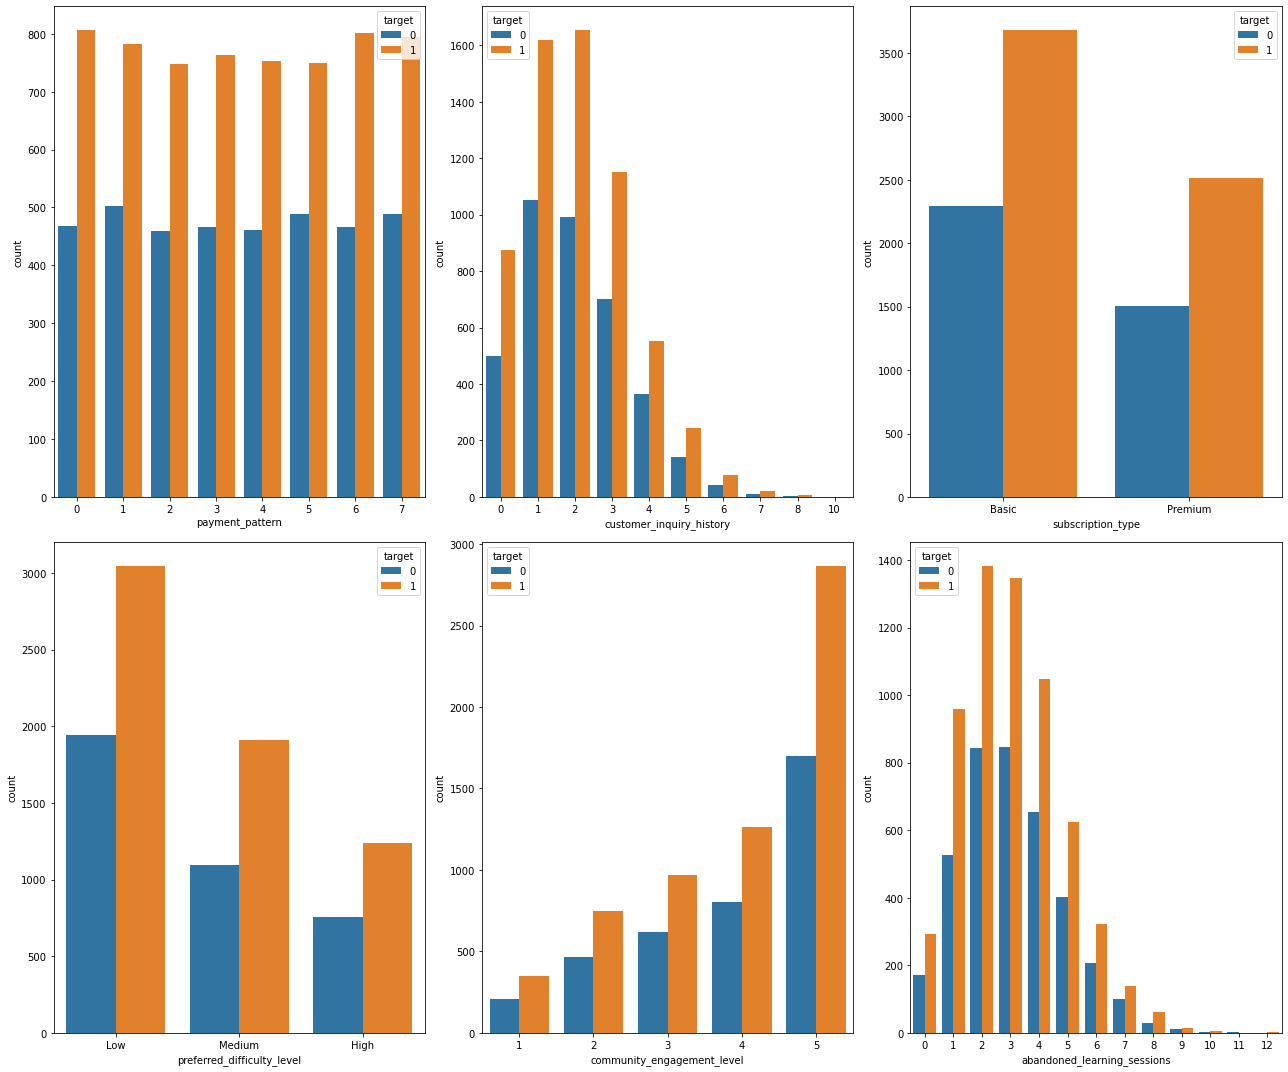

In [ ]:
num_cols = ['payment_pattern', 'customer_inquiry_history', 'subscription_type',
            'preferred_difficulty_level','community_engagement_level','abandoned_learning_sessions' ]
fig , axes = plt.subplots(2, 3, figsize = (18,15))

for i, col in enumerate(num_cols):
    row = i // 3
    col = i % 3
    sns.countplot(data= train, x= num_cols[i], hue = 'target', ax=axes[row, col])

plt.tight_layout()
plt.show()

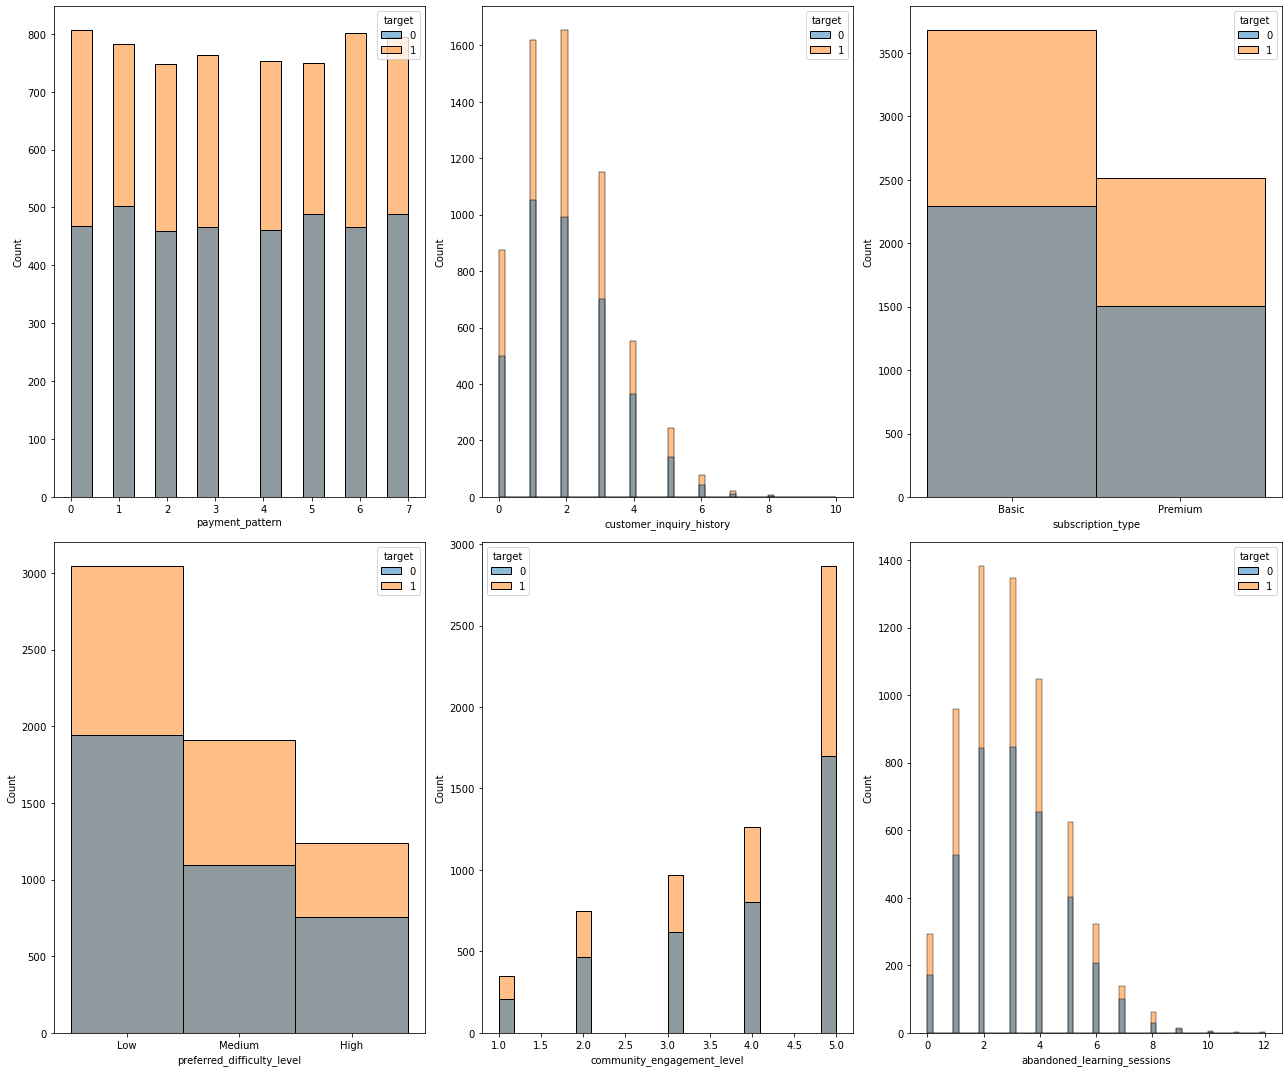

In [ ]:
num_cols = ['payment_pattern', 'customer_inquiry_history', 'subscription_type',
            'preferred_difficulty_level','community_engagement_level','abandoned_learning_sessions' ]
fig , axes = plt.subplots(2, 3, figsize = (18,15))

for i, col in enumerate(num_cols):
    row = i // 3
    col = i % 3
    sns.histplot(data= train, x= num_cols[i], hue = 'target', ax=axes[row, col])

plt.tight_layout()
plt.show()

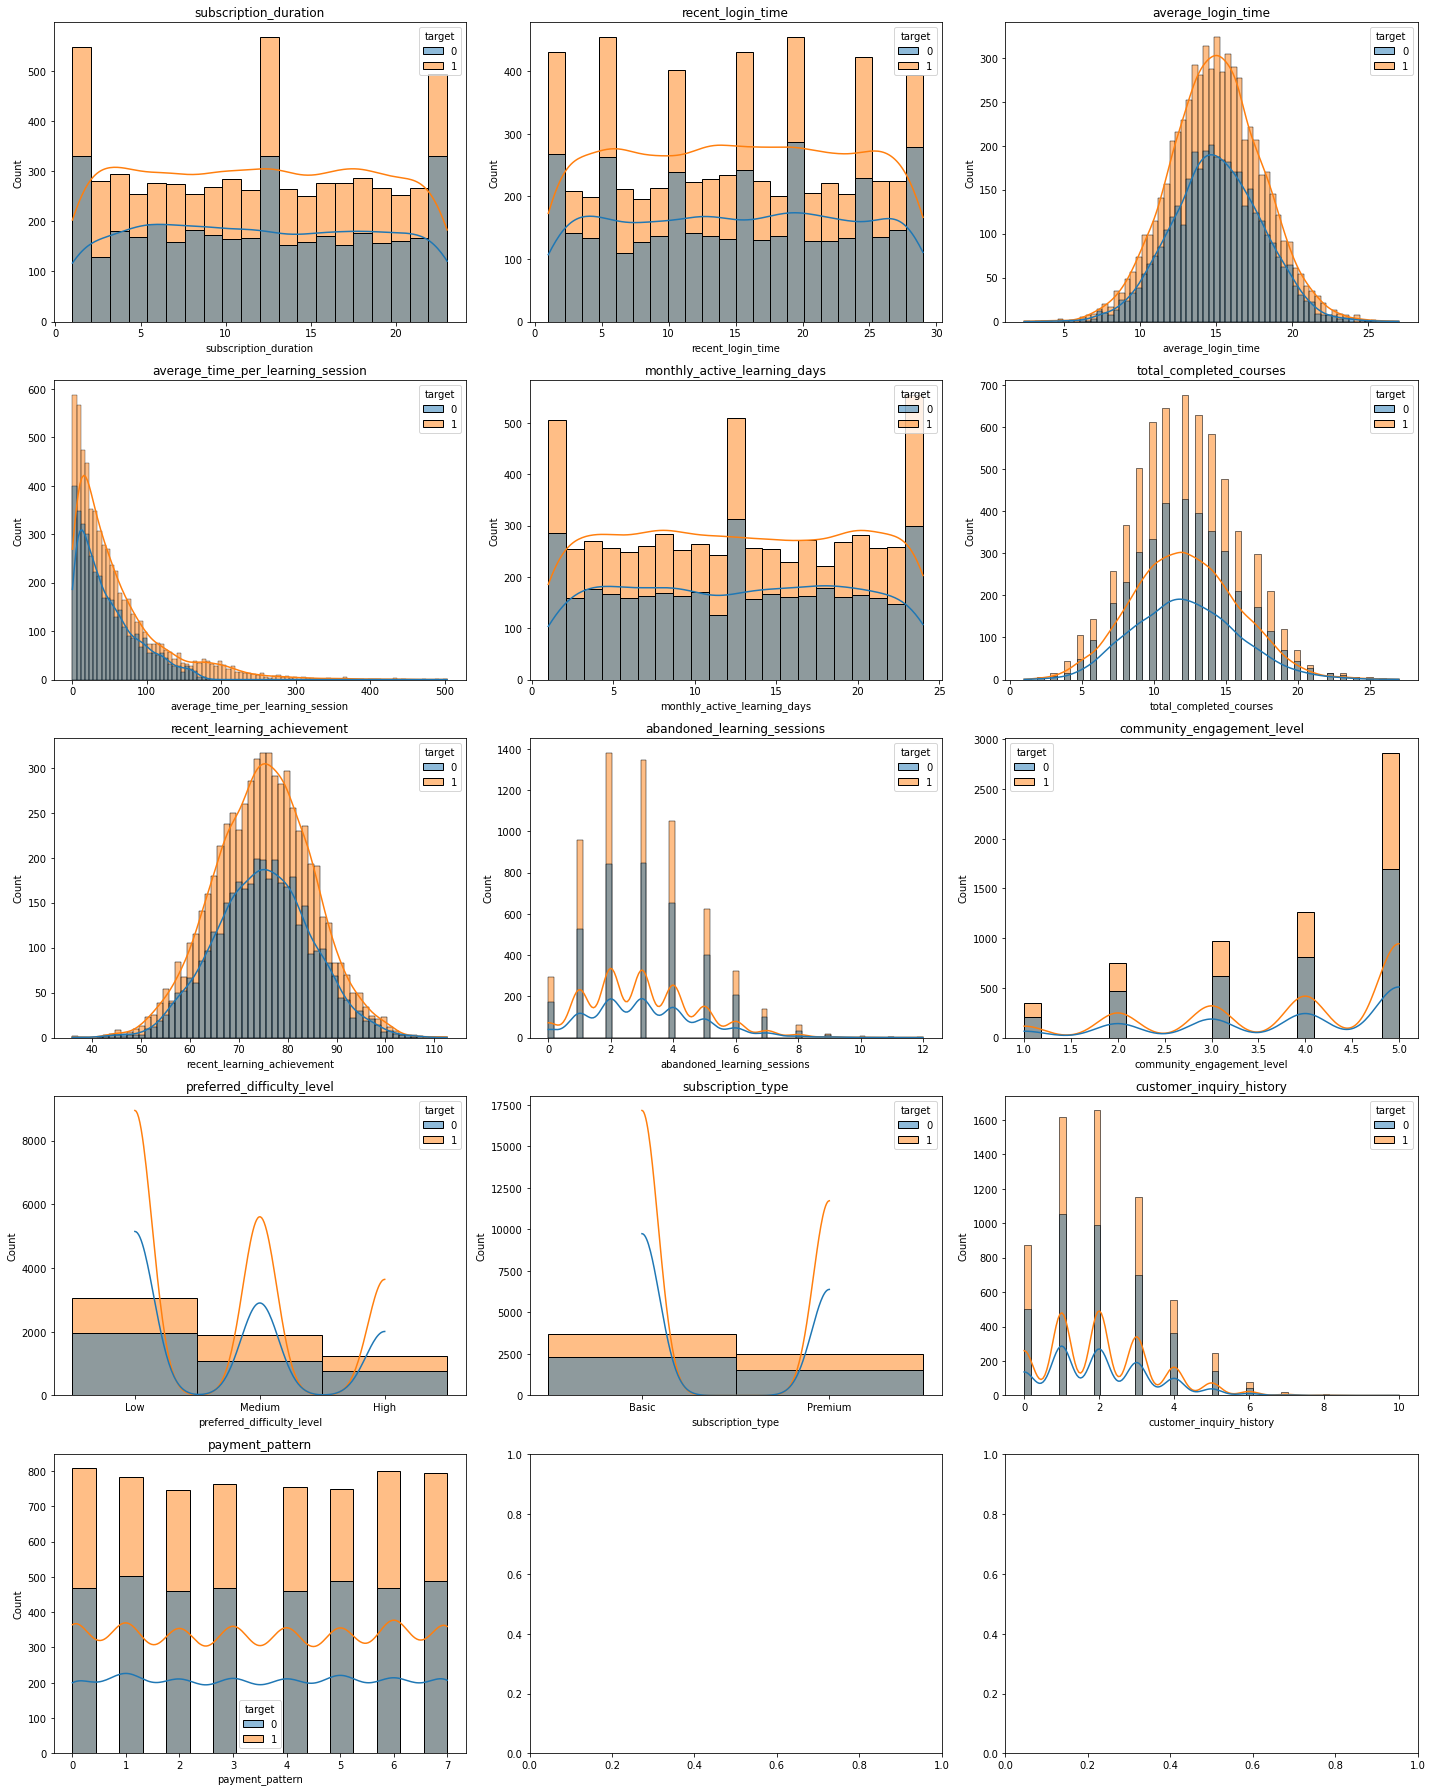

In [ ]:
col  = ['subscription_duration', 'recent_login_time',
       'average_login_time', 'average_time_per_learning_session',
       'monthly_active_learning_days', 'total_completed_courses',
       'recent_learning_achievement', 'abandoned_learning_sessions',
       'community_engagement_level', 'preferred_difficulty_level',
       'subscription_type', 'customer_inquiry_history', 'payment_pattern'
       ]
fig, axes = plt.subplots(5, 3, figsize=(20, 25))

for i, col in enumerate(col):
    row = i // 3
    col_index = i % 3
    sns.histplot(data= train, x=col, hue="target", ax=axes[row, col_index], kde=True)
    axes[row, col_index].set_title(col)

for i in range(len(col), 15):
    axes[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show()

# 데이터 전처리

In [ ]:
df_train = train.copy()
df_test = test.copy()

In [ ]:
num_cols = [col for col in train.columns if train[col].dtype in ['int64', 'float64'] and col not in ['target']]
cat_cols = [col for col in train.columns if train[col].dtype == 'object' and col not in ['user_id']]

scaler = StandardScaler()

df_train[num_cols] = scaler.fit_transform(df_train[num_cols])
df_test[num_cols] = scaler.transform(df_test[num_cols])

label_encoders = {}

for col in cat_cols:
    label_encoders[col] = LabelEncoder()
    df_train[col] = label_encoders[col].fit_transform(df_train[col])
    df_test[col] = label_encoders[col].transform(df_test[col])



- basic modeling

In [ ]:
X = df_train.drop(columns = ['user_id', 'target'])
y = df_train['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

models = {"RF" : RandomForestClassifier(random_state=42),
        "SVM" : SVC(),
        "DT" : DecisionTreeClassifier(random_state=42),
        "XGB" : XGBClassifier(random_state=42),
        "LR" : LogisticRegression(random_state=42),
        "Knn" : KNeighborsClassifier(),
        "GB" : GradientBoostingClassifier(random_state=42)}
best_score = 0
best_model = " "

for name , model in models.items():
    model.fit(X_train, y_train)
    val_prediction = model.predict(X_val)
    val_f1 = f1_score(y_val, val_prediction, average='macro', zero_division = 0)
    print(f"{name} val_data Macro F1 Score : ", val_f1)
    print(classification_report(y_val, val_prediction, zero_division=0))
    if val_f1 > best_score:
        best_score = val_f1
        best_model = name

print(f"Best_model : {best_model} , Macro F1_score : {best_score}")


RF val_data Macro F1 Score :  0.45068219333017506
              precision    recall  f1-score   support

           0       0.38      0.11      0.17       758
           1       0.62      0.89      0.73      1242

    accuracy                           0.59      2000
   macro avg       0.50      0.50      0.45      2000
weighted avg       0.53      0.59      0.52      2000

SVM val_data Macro F1 Score :  0.3843404808317089
              precision    recall  f1-score   support

           0       0.50      0.00      0.00       758
           1       0.62      1.00      0.77      1242

    accuracy                           0.62      2000
   macro avg       0.56      0.50      0.38      2000
weighted avg       0.58      0.62      0.48      2000

DT val_data Macro F1 Score :  0.5202304160721227
              precision    recall  f1-score   support

           0       0.40      0.42      0.41       758
           1       0.64      0.62      0.63      1242

    accuracy                     

In [ ]:
DecisionTree_model = DecisionTreeClassifier()
DecisionTree_model.fit(X, y)
test_X = df_test.drop(columns=['user_id'])
DT_pred = DecisionTree_model.predict(test_X)

In [ ]:
# score : 0.52839(11.25)

# submission['target'] = DT_pred
# submit_path = "/Users/seungho/Desktop/승호/공모전 및 프로젝트/데이콘/데이콘 이용자 구독예측/(11.25)DT_basic.csv"
# submission.to_csv(submit_path, index=False)


In [ ]:
 ! pip install optuna


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


- step (1) 피처엔지니어링전
- Optuna로 hyperparameter 최적화
  * hyperparameter 튜닝 할수록 성능이 낮아지는 것을 확인 ('min_samples_split' 추가시 Score : 0.43547801387136903)



In [ ]:
# optuna

def objective(trial):
    param = {
        'max_depth' : trial.suggest_int('max_depth', 1, 64),
        # 'min_samples_split' : trial.suggest_float('min_samples_split', 0.1, 1.0),
        # 'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 10),
        # 'criterion' : trial.suggest_categorical('criterion',['gini','entropy']),
        # 'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2', None]),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        # 'splitter': trial.suggest_categorical('splitter', ['best', 'random'])

    }
    clf = DecisionTreeClassifier(**param)
    f1_macro = make_scorer(f1_score, average='macro')
    scores = cross_val_score(clf, X, y, n_jobs = -1, cv = 5, scoring = f1_macro)

    return np.mean(scores)

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials=200)

print(f"Best trial : {study.best_trial.params}")

best_parmas = study.best_trial.params
model = DecisionTreeClassifier(**best_parmas)
model.fit(X,y)

predictions = model.predict(test_X)

print(predictions)

[I 2023-11-26 17:17:54,410] A new study created in memory with name: no-name-ea382448-7dea-4b4a-9961-7aaa473a011c
[I 2023-11-26 17:17:54,441] Trial 0 finished with value: 0.38267793367103853 and parameters: {'max_depth': 1, 'class_weight': None}. Best is trial 0 with value: 0.38267793367103853.
[I 2023-11-26 17:17:54,555] Trial 1 finished with value: 0.5158203956228349 and parameters: {'max_depth': 64, 'class_weight': None}. Best is trial 1 with value: 0.5158203956228349.
[I 2023-11-26 17:17:54,594] Trial 2 finished with value: 0.3905055167343906 and parameters: {'max_depth': 3, 'class_weight': None}. Best is trial 1 with value: 0.5158203956228349.
[I 2023-11-26 17:17:54,697] Trial 3 finished with value: 0.5156157490123526 and parameters: {'max_depth': 57, 'class_weight': None}. Best is trial 1 with value: 0.5158203956228349.
[I 2023-11-26 17:17:54,799] Trial 4 finished with value: 0.5148047988288181 and parameters: {'max_depth': 30, 'class_weight': None}. Best is trial 1 with value: 0

Best trial : {'max_depth': 36, 'class_weight': 'balanced'}
[0 0 1 ... 1 1 0]


In [ ]:
plot_param_importances(study)

In [ ]:
best_parmas

{'max_depth': 47,
 'max_features': None,
 'class_weight': None,
 'splitter': 'best'}

In [ ]:
# submission['target'] = predictions
# submit_path = "/Users/seungho/Desktop/승호/공모전 및 프로젝트/데이콘/데이콘 이용자 구독예측/(11.26)DT_optuna_2.csv"
# submission.to_csv(submit_path, index=False)

- step (2) 피처엔지니어링
 * 파생변수 생성
  1) recent_login_time - average_login_time  == login_pattern  
  2) average_time_per_learning_session / monthly_active_learning_days ==
learning concentration
  3) abandoned_learning_sessions / total_completed_courses == learning persistence


  4) total_completed_courses / subscription_duration == CoursesPerMonth (미사용)

In [ ]:
train_df = train.copy()
test_df = test.copy()

In [ ]:
train_df['login_pattern'] = train_df['recent_login_time'] - train_df['average_login_time']
train_df['learning_concentration'] = train_df['average_time_per_learning_session'] / train_df['monthly_active_learning_days']
train_df['learning_persistence'] = train_df['abandoned_learning_sessions'] / train_df['total_completed_courses']
# train_df['CoursesPerMonth'] = train_df['total_completed_courses'] / train_df['subscription_duration']
# train_df['recent_achievement_per_logintime'] = train_df['recent_learning_achievement'] / train_df['recent_login_time']


test_df['login_pattern'] = test_df['recent_login_time'] - test_df['average_login_time']
test_df['learning_concentration'] = test_df['average_time_per_learning_session'] / test_df['monthly_active_learning_days']
test_df['learning_persistence'] = test_df['abandoned_learning_sessions'] / test_df['total_completed_courses']
# test_df['CoursesPerMonth'] = test_df['total_completed_courses'] / test_df['subscription_duration']
# test_df['recent_achievement_per_logintime'] = test_df['recent_learning_achievement'] / test_df['recent_login_time']

In [ ]:
num_col = [col for col in train.columns if train_df[col].dtype in ['int64', 'float64'] and col not in ['target']]
cat_col = [col for col in train.columns if train_df[col].dtype == 'object' and col not in ['user_id']]

scaler = StandardScaler()

train_df[num_col] = scaler.fit_transform(train_df[num_col])
test_df[num_col] = scaler.transform(test_df[num_col])

label_encoders = {}

for col in cat_cols:
    label_encoders[col] = LabelEncoder()
    train_df[col] = label_encoders[col].fit_transform(train_df[col])
    test_df[col] = label_encoders[col].transform(test_df[col])



In [ ]:

# train_path = "/Users/seungho/Desktop/승호/공모전 및 프로젝트/데이콘/데이콘 이용자 구독예측/train_df.csv"
# train_df.to_csv(train_path, index=False)

# test_path = "/Users/seungho/Desktop/승호/공모전 및 프로젝트/데이콘/데이콘 이용자 구독예측/test_df.csv"
# test_df.to_csv(test_path, index=False)


- 파생변수 생성후 점수 향상(ver1)
    * 이전 : Best_model : Best_model : DT , Macro F1_score : 0.5202304160721227
    * (3개 변수 추가)  : Best_model : DT , Macro F1_score : 0.5290256869181265
    * (4개 변수 추가, 'CoursesPerMonth' ) : Best_model : DT , Macro F1_score : 0.5149524228495939
    * (2개 변수 추가) : Best_model : DT , Macro F1_score : 0.5216362353717938
    * (1개 변수 추가) : Best_model : Knn , Macro F1_score : 0.5343840732746435


-  'recent_achievement_per_logintime' 추가 (ver2)
    * Best_model : DT , Macro F1_score : 0.5202805357253939  


- 3개 변수 조합이 성능이 가장 좋음


In [ ]:
#KFold
# X = train_df.drop(columns=['user_id', 'target'])
# y = train_df['target']

# models = {
#     "RF": RandomForestClassifier(random_state=42),
#     "SVM": SVC(),
#     "DT": DecisionTreeClassifier(random_state=42),
#     "XGB": XGBClassifier(random_state=42),
#     "LR": LogisticRegression(random_state=42),
#     "Knn": KNeighborsClassifier(),
#     "GB": GradientBoostingClassifier(random_state=42)
# }

# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# best_score = 0
# best_model = ""

# for name, model in models.items():
#     f1_scores = []
#     for train_index, val_index in kf.split(X):
#         X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#         y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#         model.fit(X_train, y_train)
#         val_prediction = model.predict(X_val)
#         val_f1 = f1_score(y_val, val_prediction, average='macro', zero_division=0)
#         f1_scores.append(val_f1)

#     avg_f1 = np.mean(f1_scores)
#     print(f"{name} Average Validation Macro F1 Score: {avg_f1}")

#     if avg_f1 > best_score:
#         best_score = avg_f1
#         best_model = name

# print(f"Best Model: {best_model}, Macro F1 Score: {best_score}")

In [ ]:
X = train_df.drop(columns = ['user_id', 'target'])
y = train_df['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

models = {"RF" : RandomForestClassifier(random_state=42),
        "SVM" : SVC(),
        "DT" : DecisionTreeClassifier(random_state=42),
        "XGB" : XGBClassifier(random_state=42),
        "LR" : LogisticRegression(random_state=42),
        "Knn" : KNeighborsClassifier(),
        "GB" : GradientBoostingClassifier(random_state=42)}
best_score = 0
best_model = " "

for name , model in models.items():
    model.fit(X_train, y_train)
    val_prediction = model.predict(X_val)
    val_f1 = f1_score(y_val, val_prediction, average='macro', zero_division = 0)
    print(f"{name} val_data Macro F1 Score : ", val_f1)
    print(classification_report(y_val, val_prediction, zero_division=0))
    if val_f1 > best_score:
        best_score = val_f1
        best_model = name

print(f"Best_model : {best_model} , Macro F1_score : {best_score}")

RF val_data Macro F1 Score :  0.4553057882198461
              precision    recall  f1-score   support

           0       0.37      0.12      0.19       758
           1       0.62      0.87      0.72      1242

    accuracy                           0.59      2000
   macro avg       0.50      0.50      0.46      2000
weighted avg       0.53      0.59      0.52      2000

SVM val_data Macro F1 Score :  0.38309685379395436
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       758
           1       0.62      1.00      0.77      1242

    accuracy                           0.62      2000
   macro avg       0.31      0.50      0.38      2000
weighted avg       0.39      0.62      0.48      2000

DT val_data Macro F1 Score :  0.5290256869181265
              precision    recall  f1-score   support

           0       0.41      0.45      0.43       758
           1       0.65      0.61      0.63      1242

    accuracy                     

/Users/seungho/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



GB val_data Macro F1 Score :  0.40354226557024553
              precision    recall  f1-score   support

           0       0.52      0.02      0.04       758
           1       0.62      0.99      0.76      1242

    accuracy                           0.62      2000
   macro avg       0.57      0.50      0.40      2000
weighted avg       0.58      0.62      0.49      2000

Best_model : DT , Macro F1_score : 0.5290256869181265


In [ ]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X, y)

# 피처 중요도 출력
importances = model.feature_importances_
for i in range(len(importances)):
    print(f"Feature {X.columns[i]}: Importance: {importances[i]}")

Feature subscription_duration: Importance: 0.06124630307346037
Feature recent_login_time: Importance: 0.029802125757772226
Feature average_login_time: Importance: 0.11864238398495817
Feature average_time_per_learning_session: Importance: 0.1317169776162966
Feature monthly_active_learning_days: Importance: 0.05751323843944773
Feature total_completed_courses: Importance: 0.06297905527883539
Feature recent_learning_achievement: Importance: 0.12287821792608815
Feature abandoned_learning_sessions: Importance: 0.021216314312724253
Feature community_engagement_level: Importance: 0.025775033750357227
Feature preferred_difficulty_level: Importance: 0.02015141406237779
Feature subscription_type: Importance: 0.009749608473629701
Feature customer_inquiry_history: Importance: 0.038401910949646956
Feature payment_pattern: Importance: 0.04885039813130511
Feature login_pattern: Importance: 0.0956888963138183
Feature learning_concentration: Importance: 0.08419836663823836
Feature learning_persistence: 

In [ ]:
DecisionTree_model = DecisionTreeClassifier(random_state=42)
DecisionTree_model.fit(X, y)
test_X = test_df.drop(columns=['user_id'])
DT_pred = DecisionTree_model.predict(test_X)

In [ ]:
# submission['target'] = DT_pred
# submit_path = "/Users/seungho/Desktop/승호/공모전 및 프로젝트/데이콘/데이콘 이용자 구독예측/(11.26)DT_basic2.csv"
# submission.to_csv(submit_path, index=False)

In [ ]:

# def objective(trial):
#     param = {
#         'max_depth' : trial.suggest_int('max_depth', 1, 64),
#         # 'min_samples_split' : trial.suggest_float('min_samples_split', 0.1, 1.0),
#         'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 10),
#         'criterion' : trial.suggest_categorical('criterion',['gini','entropy']),
#         'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2', None]),
#         'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
#         'splitter': trial.suggest_categorical('splitter', ['best', 'random']),
#         'random_state': 42
#     }
#     clf = DecisionTreeClassifier(**param)
#     f1_macro = make_scorer(f1_score, average='macro')
#     scores = cross_val_score(clf, X, y, n_jobs = -1, cv = 5, scoring = f1_macro)

#     return np.mean(scores)

# study = optuna.create_study(direction = 'maximize')
# study.optimize(objective, n_trials=200)

# print(f"Best trial : {study.best_trial.params}")

# best_parmas = study.best_trial.params
# model = DecisionTreeClassifier(**best_parmas)
# model.fit(X,y)

# predictions = model.predict(test_X)

# print(predictions)

[I 2023-11-26 19:25:13,707] A new study created in memory with name: no-name-25866efa-01d0-45a6-9994-3e61f200fa9a
[I 2023-11-26 19:25:13,867] Trial 0 finished with value: 0.5155713343890661 and parameters: {'max_depth': 17, 'min_samples_leaf': 5, 'criterion': 'entropy', 'max_features': None, 'class_weight': 'balanced', 'splitter': 'random'}. Best is trial 0 with value: 0.5155713343890661.
/Users/seungho/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/seungho/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/seungho/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:26

Best trial : {'max_depth': 46, 'min_samples_leaf': 4, 'criterion': 'entropy', 'max_features': None, 'class_weight': 'balanced', 'splitter': 'best'}
[1 0 1 ... 0 0 1]


In [ ]:
# submission['target'] = predictions
# submit_path = "/Users/seungho/Desktop/승호/공모전 및 프로젝트/데이콘/데이콘 이용자 구독예측/(11.26)DT_Optuna3.csv"
# submission.to_csv(submit_path, index=False)

In [ ]:
# plot_param_importances(study)

- step(3) 변수선택

1) 피처 중요도를 이용한 변수 선택(randomforest)

2) 재귀적 특성제거(RFE)

3) L1 (Lasso) 정규화를 이용한 변수 선택

In [ ]:
# 변수선택 RFE
model = DecisionTreeClassifier(random_state=42)

rfe = RFE(estimator=model, n_features_to_select=10) # n_features_to_select는 선택할 피처의 수
rfe.fit(X, y)

for i in range(X.shape[1]):
    print(f"Feature {X.columns[i]}: Selected {rfe.support_[i]}, Rank: {rfe.ranking_[i]}")


Feature subscription_duration: Selected True, Rank: 1
Feature recent_login_time: Selected False, Rank: 3
Feature average_login_time: Selected True, Rank: 1
Feature average_time_per_learning_session: Selected True, Rank: 1
Feature monthly_active_learning_days: Selected True, Rank: 1
Feature total_completed_courses: Selected True, Rank: 1
Feature recent_learning_achievement: Selected True, Rank: 1
Feature abandoned_learning_sessions: Selected False, Rank: 6
Feature community_engagement_level: Selected False, Rank: 4
Feature preferred_difficulty_level: Selected False, Rank: 5
Feature subscription_type: Selected False, Rank: 7
Feature customer_inquiry_history: Selected False, Rank: 2
Feature payment_pattern: Selected True, Rank: 1
Feature login_pattern: Selected True, Rank: 1
Feature learning_concentration: Selected True, Rank: 1
Feature learning_persistence: Selected True, Rank: 1


In [ ]:
model = DecisionTreeClassifier(random_state=42)

rfecv = RFECV(
    estimator=model,
    step=1,
    cv=StratifiedKFold(5), # 5-폴드 교차 검증
    scoring=make_scorer(f1_score, average='macro')
)

rfecv.fit(X, y)

print("Optimal number of features: ", rfecv.n_features_)
print("Best features: ", X.columns[rfecv.support_])

for i in range(X.shape[1]):
    print(f"Feature {X.columns[i]}: Selected {rfecv.support_[i]}, Rank: {rfecv.ranking_[i]}")


Optimal number of features:  10
Best features:  Index(['subscription_duration', 'average_login_time',
       'average_time_per_learning_session', 'monthly_active_learning_days',
       'total_completed_courses', 'recent_learning_achievement',
       'payment_pattern', 'login_pattern', 'learning_concentration',
       'learning_persistence'],
      dtype='object')
Feature subscription_duration: Selected True, Rank: 1
Feature recent_login_time: Selected False, Rank: 3
Feature average_login_time: Selected True, Rank: 1
Feature average_time_per_learning_session: Selected True, Rank: 1
Feature monthly_active_learning_days: Selected True, Rank: 1
Feature total_completed_courses: Selected True, Rank: 1
Feature recent_learning_achievement: Selected True, Rank: 1
Feature abandoned_learning_sessions: Selected False, Rank: 6
Feature community_engagement_level: Selected False, Rank: 4
Feature preferred_difficulty_level: Selected False, Rank: 5
Feature subscription_type: Selected False, Rank: 7
Fea

In [ ]:

# def objective(trial):
#     param = {
#         'max_depth' : trial.suggest_int('max_depth', 1, 64),
#         # 'min_samples_split' : trial.suggest_float('min_samples_split', 0.1, 1.0),
#         'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 10),
#         'criterion' : trial.suggest_categorical('criterion',['gini','entropy']),
#         'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2', None]),
#         'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
#         'splitter': trial.suggest_categorical('splitter', ['best', 'random']),
#         'random_state': 42
#     }
#     clf = DecisionTreeClassifier(**param)
#     f1_macro = make_scorer(f1_score, average='macro')
#     scores = cross_val_score(clf, X, y, n_jobs = -1, cv = 5, scoring = f1_macro)

#     return np.mean(scores)

# study = optuna.create_study(direction = 'maximize')
# study.optimize(objective, n_trials=200)

# print(f"Best trial : {study.best_trial.params}")

# best_parmas = study.best_trial.params
# model = DecisionTreeClassifier(**best_parmas)
# model.fit(X,y)

# predictions = model.predict(test_X)

# print(predictions)

In [ ]:
# plot_param_importances(study)

- 파생변수 생성후 점수 향상 (변수제거전)
    * 이전 : Best_model : Best_model : DT , Macro F1_score : 0.5202304160721227
    * (3개 변수 추가)  : Best_model : DT , Macro F1_score : 0.5290256869181265
    * (4개 변수 추가) : Best_model : DT , Macro F1_score : 0.5149524228495939
    * (2개 변수 추가) : Best_model : DT , Macro F1_score : 0.5216362353717938
    * (1개 변수 추가) : Best_model : Knn , Macro F1_score : 0.5343840732746435

- 변수제거전 optuna
    * Best is trial 82 with value: 0.5289349870149287.   

- 변수제거 후 optuna(점수 감소)
    * Best is trial 41 with value: 0.526145342878025.  